In [178]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Loading dataset

In [151]:
df=pd.read_csv('Finaldataset(Sheet1) (2).csv')

# Data cleaning

In [152]:
df.head()

,Claimid,Patientid,AdmissionId,Age,Gender,Diagnosis Code,Diagnosis Score,Smoke,Alcohol,BMI,...,METABOLIC: GLUCOSE,METABOLIC: CREATININE,METABOLIC: BUN,METABOLIC: BILI TOTAL,METABOLIC: ALBUMIN,METABOLIC: SODIUM,METABOLIC: POTASSIUM,URINALYSIS: PH,URINALYSIS: RED BLOOD CELLS,URINALYSIS: WHITE BLOOD CELLS
0,L31141,01709EAC-E22B-4083-B044-61E830B1745B,1,23,Female,C65.6,5,No,No,23.5,...,62.6 mg/dL,0.6 mg/dL,18.4 mg/dL,0.5 mg/dL,3.1 gm/dL,152.6 mmol/L,5.2 mmol/L,4.7 no unit,1.5 rbc/hpf,1.9 wbc/hpf
1,T85978,03C56DF5-B647-45BE-8FF3-A57498007059,1,20,Male,M1A.3,4,No,No,18.6,...,125.5 mg/dL,1.1 mg/dL,23.8 mg/dL,0.6 mg/dL,4.5 gm/dL,135.5 mmol/L,5.5 mmol/L,6.0 no unit,3.5 rbc/hpf,1.7 wbc/hpf
2,N03319,03C56DF5-B647-45BE-8FF3-A57498007059,2,44,Male,M26.6,2,Yes,No,24.9,...,60.4 mg/dL,0.9 mg/dL,8.3 mg/dL,0.1 mg/dL,4.0 gm/dL,129.2 mmol/L,5.1 mmol/L,4.9 no unit,0.7 rbc/hpf,2.4 wbc/hpf
3,N00680,03C56DF5-B647-45BE-8FF3-A57498007059,3,45,Male,D37.4,3,Yes,Yes,25.2,...,136.7 mg/dL,0.7 mg/dL,12.1 mg/dL,0.1 mg/dL,5.2 gm/dL,149.7 mmol/L,5.1 mmol/L,5.2 no unit,1.8 rbc/hpf,4.1 wbc/hpf
4,E85854,03C56DF5-B647-45BE-8FF3-A57498007059,4,46,Male,M63.8,2,Yes,Yes,27.0,...,126.9 mg/dL,0.8 mg/dL,19.3 mg/dL,0.4 mg/dL,4.8 gm/dL,128.8 mmol/L,5.6 mmol/L,5.7 no unit,2.1 rbc/hpf,2.4 wbc/hpf


In [153]:
df.isnull().sum()

Claimid                            0
Patientid                          0
AdmissionId                        0
Age                                0
Gender                             0
Diagnosis Code                     0
Diagnosis Score                    0
Smoke                              0
Alcohol                            0
BMI                                0
Exercise Frequency                 0
CBC: RED BLOOD CELL COUNT          0
CBC: WHITE BLOOD CELL COUNT        0
CBC: HEMOGLOBIN                    0
CBC: PLATELET COUNT                0
Unnamed: 15                      468
METABOLIC: ALT/SGPT                0
METABOLIC: AST/SGOT                0
METABOLIC: GLUCOSE                 0
METABOLIC: CREATININE              0
METABOLIC: BUN                     0
METABOLIC: BILI TOTAL              0
METABOLIC: ALBUMIN                 0
METABOLIC: SODIUM                  0
METABOLIC: POTASSIUM               0
URINALYSIS: PH                     0
URINALYSIS: RED BLOOD CELLS        0
U

In [154]:
df=df.dropna(axis=1,how='any')

In [155]:
df.columns = [col.replace(':', '_') for col in df.columns]
df.columns = [col.replace('/', '_') for col in df.columns]
df.columns = [col.replace(' ', '_') for col in df.columns]

In [156]:
import re

def extract_float(value):
    try:
        return float(re.findall(r"[-+]?\d*\.\d+|\d+", str(value))[0])
    except:
        return None

columns_to_clean = ['CBC__RED_BLOOD_CELL_COUNT', 'CBC__WHITE_BLOOD_CELL_COUNT', 'CBC__HEMOGLOBIN', 
                    'CBC__PLATELET_COUNT', 'METABOLIC__CREATININE', 'METABOLIC__BUN', 'METABOLIC__BILI_TOTAL', 
                    'METABOLIC__ALBUMIN', 'METABOLIC__SODIUM', 'METABOLIC__GLUCOSE', 'METABOLIC__POTASSIUM', 
                    'URINALYSIS__PH', 'URINALYSIS__RED_BLOOD_CELLS', 'URINALYSIS__WHITE_BLOOD_CELLS', 
                    'METABOLIC__ALT_SGPT', 'METABOLIC__AST_SGOT']

for col in columns_to_clean:
    df[col] = df[col].apply(extract_float)

# Data preprocessing

In [157]:
categorical_features = ['Diagnosis_Code','Smoke', 'Alcohol', 'Exercise_Frequency', 'Gender']
numeric_features = ['Age', 'BMI', 'CBC__RED_BLOOD_CELL_COUNT', 'CBC__WHITE_BLOOD_CELL_COUNT', 'CBC__HEMOGLOBIN', 
                    'CBC__PLATELET_COUNT', 'METABOLIC__CREATININE', 'METABOLIC__BUN', 'METABOLIC__BILI_TOTAL', 
                    'METABOLIC__ALBUMIN', 'METABOLIC__SODIUM', 'METABOLIC__GLUCOSE', 'METABOLIC__POTASSIUM', 
                    'URINALYSIS__PH', 'URINALYSIS__RED_BLOOD_CELLS', 'URINALYSIS__WHITE_BLOOD_CELLS', 
                    'METABOLIC__ALT_SGPT', 'METABOLIC__AST_SGOT']

In [158]:
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le 

# Feature Engineering

In [159]:
df['avg_risk_score'] = df.groupby('Patientid')['Diagnosis_Score'].transform('mean')
df['claim_frequency'] = df.groupby('Patientid')['Claimid'].transform('count')


In [160]:
X=df.drop(columns=['Claimid','Patientid','AdmissionId','Diagnosis_Score'])
Y=df['Diagnosis_Score']

# Training and testing

In [161]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scaling numeric features
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Hyperparameter tuning

In [181]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2',None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [164]:
model = RandomForestRegressor(n_estimators=100,random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [182]:
# Evaluate using cross-validation on training data
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE Scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean()}")

Cross-Validation RMSE Scores: [0.79959991 0.88844843 0.7735974  0.79310933 0.88370893]
Mean CV RMSE: 0.8276928010630229


In [165]:
best_model = grid_search.best_estimator_

In [184]:
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                          Feature  Importance
23                 avg_risk_score    0.446776
2                  Diagnosis_Code    0.142521
16          METABOLIC__BILI_TOTAL    0.029319
9                 CBC__HEMOGLOBIN    0.026626
18              METABOLIC__SODIUM    0.026171
15                 METABOLIC__BUN    0.025411
13             METABOLIC__GLUCOSE    0.025134
8     CBC__WHITE_BLOOD_CELL_COUNT    0.024757
5                             BMI    0.023282
20                 URINALYSIS__PH    0.023162
12            METABOLIC__AST_SGOT    0.022470
11            METABOLIC__ALT_SGPT    0.022117
19           METABOLIC__POTASSIUM    0.021379
10            CBC__PLATELET_COUNT    0.021293
22  URINALYSIS__WHITE_BLOOD_CELLS    0.020252
17             METABOLIC__ALBUMIN    0.019231
0                             Age    0.017091
7       CBC__RED_BLOOD_CELL_COUNT    0.016211
21    URINALYSIS__RED_BLOOD_CELLS    0.016084
14          METABOLIC__CREATININE    0.009387
6              Exercise_Frequency 

# Evaluation

In [166]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

Y_pred = best_model.predict(X_test)
mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test,Y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'RMSE: {rmse}')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
RMSE: 0.7721666347970942
Mean Squared Error (MSE): 0.5962413118938691
Mean Absolute Error (MAE): 0.6150965327029155
R-squared (R²): 0.4767194843172201


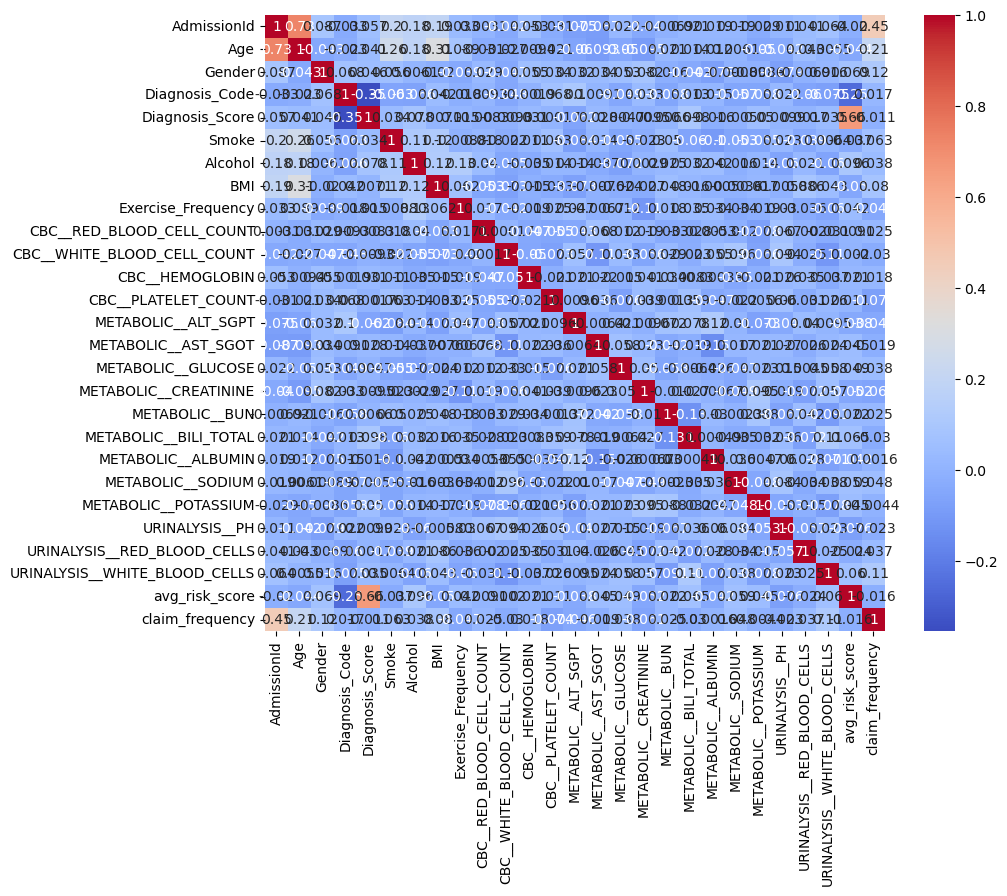

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns 

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Preventive measures 

In [168]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

C:\Users\Jayalakshmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [169]:
def recommend(patient_data):
    recommendations = []
    if patient_data['Smoke'] == 1:  # If Smoker
        recommendations.append('Quit smoking')
    if patient_data['Age'] > 50:  # If age is high (standardized value)
        recommendations.append('Do regular hospital visits and full body checkups')
    if patient_data['Alcohol'] == 1:
        recommendations.append('Liquor is injurious to health. Please stop drinking')
    if patient_data['Exercise_Frequency'] == 0 and patient_data['BMI'] > 25:
        recommendations.append('Exercise daily to reduce your weight')
    
    # CBC thresholds
    if patient_data['CBC__RED_BLOOD_CELL_COUNT'] < 4.0:
        recommendations.append('Your red blood cell count is low. Consider eating iron-rich foods like spinach, beans, and red meat. Consult a hematologist.')
    elif patient_data['CBC__RED_BLOOD_CELL_COUNT'] > 5.2:
        recommendations.append('Your red blood cell count is high. Stay hydrated and consult a hematologist for further evaluation.')
    
    if patient_data['CBC__WHITE_BLOOD_CELL_COUNT'] < 4.5:
        recommendations.append('Your white blood cell count is low. A healthy diet, regular exercise, and adequate sleep can help boost your immune system. Consult a hematologist.')
    elif patient_data['CBC__WHITE_BLOOD_CELL_COUNT'] > 13.5:
        recommendations.append('Your white blood cell count is high. This could indicate an infection or inflammation. Consult an infectious disease specialist.')
    
    if patient_data['CBC__HEMOGLOBIN'] < 12.0:
        recommendations.append('Your hemoglobin level is low. Include iron and vitamin C-rich foods in your diet to help increase your levels. Consult a hematologist.')
    elif patient_data['CBC__HEMOGLOBIN'] > 15.0:
        recommendations.append('Your hemoglobin level is high. Ensure you stay well-hydrated and consult a hematologist.')
    
    if patient_data['CBC__PLATELET_COUNT'] < 150:
        recommendations.append('Your platelet count is low. Foods rich in folate, vitamin B12, and iron may help increase your levels. Consult a hematologist.')
    elif patient_data['CBC__PLATELET_COUNT'] > 450:
        recommendations.append('Your platelet count is high. It could be due to various conditions. Consult a hematologist for a thorough evaluation.')

    # Metabolic panel thresholds
    if patient_data['METABOLIC__ALT_SGPT'] < 10:
        recommendations.append('Your ALT/SGPT level is low. Ensure you have a balanced diet and consult your primary care physician.')
    elif patient_data['METABOLIC__ALT_SGPT'] > 40:
        recommendations.append('Your ALT/SGPT level is high. Avoid alcohol and fatty foods. Consult a hepatologist for liver health evaluation.')
    
    if patient_data['METABOLIC__AST_SGOT'] < 10:
        recommendations.append('Your AST/SGOT level is low. Maintain a balanced diet and regular exercise. Consult your primary care physician.')
    elif patient_data['METABOLIC__AST_SGOT'] > 40:
        recommendations.append('Your AST/SGOT level is high. Reduce alcohol intake and avoid hepatotoxic drugs. Consult a hepatologist.')
    
    if patient_data['METABOLIC__GLUCOSE'] < 70:
        recommendations.append('Your glucose level is low. Eat small, frequent meals rich in complex carbohydrates and proteins. Consult an endocrinologist.')
    elif patient_data['METABOLIC__GLUCOSE'] > 100:
        recommendations.append('Your glucose level is high. Reduce sugar and refined carbs in your diet, and increase physical activity. Consult an endocrinologist.')
    
    if patient_data['METABOLIC__CREATININE'] < 0.5:
        recommendations.append('Your creatinine level is low. Ensure you have adequate protein intake. Consult a nephrologist.')
    elif patient_data['METABOLIC__CREATININE'] > 1.0:
        recommendations.append('Your creatinine level is high. Stay hydrated and consult a nephrologist for kidney function assessment.')
    
    if patient_data['METABOLIC__BUN'] < 7:
        recommendations.append('Your BUN level is low. Ensure you have a balanced diet with enough protein. Consult a nephrologist.')
    elif patient_data['METABOLIC__BUN'] > 20:
        recommendations.append('Your BUN level is high. Stay hydrated and reduce protein intake if advised by your doctor. Consult a nephrologist.')
    
    if patient_data['METABOLIC__BILI_TOTAL'] < 0.1:
        recommendations.append('Your bilirubin level is low. Ensure proper nutrition and liver health. Consult your primary care physician.')
    elif patient_data['METABOLIC__BILI_TOTAL'] > 1.2:
        recommendations.append('Your bilirubin level is high. Avoid alcohol and fatty foods. Consult a hepatologist for liver health assessment.')
    
    if patient_data['METABOLIC__ALBUMIN'] < 3.5:
        recommendations.append('Your albumin level is low. Include protein-rich foods like eggs, meat, and dairy in your diet. Consult a nutritionist or your primary care physician.')
    elif patient_data['METABOLIC__ALBUMIN'] > 5.0:
        recommendations.append('Your albumin level is high. Ensure you are hydrated and consult your primary care physician.')
    
    if patient_data['METABOLIC__SODIUM'] < 135:
        recommendations.append('Your sodium level is low. Include electrolyte-rich foods and drinks in your diet. Consult a nephrologist.')
    elif patient_data['METABOLIC__SODIUM'] > 145:
        recommendations.append('Your sodium level is high. Reduce salt intake and drink more water. Consult a nephrologist.')
    
    if patient_data['METABOLIC__POTASSIUM'] < 3.5:
        recommendations.append('Your potassium level is low. Include potassium-rich foods like bananas, oranges, and spinach in your diet. Consult a nephrologist.')
    elif patient_data['METABOLIC__POTASSIUM'] > 5.1:
        recommendations.append('Your potassium level is high. Avoid high-potassium foods and consult a nephrologist.')

    # Urinalysis thresholds
    if patient_data['URINALYSIS__RED_BLOOD_CELLS'] > 2:
        recommendations.append('Red blood cells in urine are above the normal range. Increase water intake and consult a urologist.')
    
    if patient_data['URINALYSIS__WHITE_BLOOD_CELLS'] > 5:
        recommendations.append('White blood cells in urine are above the normal range. This may indicate an infection. Drink plenty of fluids and consult a urologist.')

    recommendations.append('Take care!')
    return recommendations

In [170]:
df['recommendations'] = df.apply(recommend, axis=1)

print(df[['Patientid', 'recommendations']])

                                Patientid  \
0    01709EAC-E22B-4083-B044-61E830B1745B   
1    03C56DF5-B647-45BE-8FF3-A57498007059   
2    03C56DF5-B647-45BE-8FF3-A57498007059   
3    03C56DF5-B647-45BE-8FF3-A57498007059   
4    03C56DF5-B647-45BE-8FF3-A57498007059   
..                                    ...   
463  F691AA45-1D7C-4442-B547-585F09045B96   
464  F691AA45-1D7C-4442-B547-585F09045B96   
465  F691AA45-1D7C-4442-B547-585F09045B97   
466  F691AA45-1D7C-4442-B547-585F09045B98   
467  F691AA45-1D7C-4442-B547-585F09045B99   

                                       recommendations  
0    [Your hemoglobin level is high. Ensure you sta...  
1    [Your red blood cell count is low. Consider ea...  
2    [Quit smoking, Your red blood cell count is lo...  
3    [Quit smoking, Liquor is injurious to health. ...  
4    [Quit smoking, Liquor is injurious to health. ...  
..                                                 ...  
463  [Do regular hospital visits and full body chec...  
464

# Sample input prediction

In [175]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

input_data = (23, 'Female','G73','Yes','No',27.9,'daily',6.2, 9.1, 12.7, 429.5, 71.0, 17.6, 96.8, 1.1, 22.9, 1.2, 3.8, 129.9, 4.9, 4.6, 1.3, 2.3, 3.6, 5)
input_data_as_numpy_array = np.asarray(input_data).reshape(1, -1)

# Convert categorical features to the right format
for i, feature in enumerate(categorical_features):
    feature_index = X.columns.get_loc(feature)
    if input_data_as_numpy_array[0, feature_index] in label_encoders[feature].classes_:
        input_data_as_numpy_array[0, feature_index] = label_encoders[feature].transform([input_data_as_numpy_array[0, feature_index]])[0]
    else:
        raise ValueError(f"Unseen label '{input_data_as_numpy_array[0, feature_index]}' for feature '{feature}'")

# Convert the modified array back to a numerical type array
input_data_as_numpy_array = input_data_as_numpy_array.astype(float)

# Scale numeric features in the input data
input_data_numeric = input_data_as_numpy_array[:, [X.columns.get_loc(f) for f in numeric_features]]
input_data_numeric_scaled = scaler.transform(input_data_numeric)

# Create a final input array for prediction
final_input_data = input_data_as_numpy_array.copy()
numeric_indices = [X.columns.get_loc(f) for f in numeric_features]
final_input_data[:, numeric_indices] = input_data_numeric_scaled

true_label=np.array([3])
# Prediction
prediction = best_model.predict(final_input_data)
correct_prediction=np.round(prediction)

# Print results
print(f"The predicted output is {correct_prediction}")
print(f"the true test label is {true_label}")

The predicted output is [3.]
the true test label is [3]


C:\Users\Jayalakshmi\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Jayalakshmi\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [192]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [193]:
filename="model_rf.sav"
pickle.dump(best_model,open(filename,'wb'))

In [194]:
filescaler="scaler.pkl"
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

In [195]:
loaded_model=pickle.load(open('model_rf.sav','rb'))


In [196]:
scaler=pickle.load(open('scaler.pkl','rb'))

In [197]:
input_data = (23, 'Female','G73','Yes','No',27.9,'daily',6.2, 9.1, 12.7, 429.5, 71.0, 17.6, 96.8, 1.1, 22.9, 1.2, 3.8, 129.9, 4.9, 4.6, 1.3, 2.3, 3.6, 5)
input_data_as_numpy_array = np.asarray(input_data).reshape(1, -1)

# Convert categorical features to the right format
for i, feature in enumerate(categorical_features):
    feature_index = X.columns.get_loc(feature)
    if input_data_as_numpy_array[0, feature_index] in label_encoders[feature].classes_:
        input_data_as_numpy_array[0, feature_index] = label_encoders[feature].transform([input_data_as_numpy_array[0, feature_index]])[0]
    else:
        raise ValueError(f"Unseen label '{input_data_as_numpy_array[0, feature_index]}' for feature '{feature}'")

# Convert the modified array back to a numerical type array
input_data_as_numpy_array = input_data_as_numpy_array.astype(float)

# Scale numeric features in the input data
input_data_numeric = input_data_as_numpy_array[:, [X.columns.get_loc(f) for f in numeric_features]]
input_data_numeric_scaled = scaler.transform(input_data_numeric)

# Create a final input array for prediction
final_input_data = input_data_as_numpy_array.copy()
numeric_indices = [X.columns.get_loc(f) for f in numeric_features]
final_input_data[:, numeric_indices] = input_data_numeric_scaled

true_label=np.array([3])
# Prediction
prediction = best_model.predict(final_input_data)
correct_prediction=np.round(prediction)

# Print results
print(f"The predicted output is {correct_prediction}")
print(f"the true test label is {true_label}")

The predicted output is [3.]
the true test label is [3]


C:\Users\Jayalakshmi\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Jayalakshmi\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
